# *Library and file dependancies*

In [113]:

# Single cell 
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
from kneed import KneeLocator
import matplotlib.pyplot as plt
import seaborn as sns
# Consider aesthetics
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['axes.axisbelow'] = True
plt.rcParams.update({'font.size': 17})
# CLustering 
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_mutual_info_score
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import fowlkes_mallows_score
#Optimization
import optuna
# Output control
import warnings
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings("ignore")

In [114]:
from utils.optimization import optimizeGMM

In [115]:
adata = sc.read('datasets/dimreduced_cellcounts.h5ad')

# **Researchers' cancer/non-cancer cell seperation results**

For the seperation of cancer with non-cancer cells the researchers used the chromosomal gene
expression patterns, since we will utilize clustering directly on the sc-Dataset. We first load the cluster labels the researchers infered to compare them with our own method.

In [116]:
df = pd.read_csv("datasets/GSE75688_final_sample_information.txt", delimiter="\t")
df_sorted = df.sort_values(by='sample', ascending=True)
df_sorted = pd.concat([df[df['sample'].str.split('_', expand=True)[1] == 'Pooled'],
                      df[df['sample'].str.split('_', expand=True)[1] != 'Pooled']])

pooled_names = df.loc[df['sample'].str.contains('_Pooled'), 'sample']

mask = df['sample'].isin(pooled_names)

sorted_lines = df[mask].sort_values(by='sample')

df_sorted = pd.concat([sorted_lines, df[~mask]])
# rename the BC07_Pooled as BC07_Tumor
df_sorted.loc[129, 'sample'] = 'BC07_Tumor'

bulk_rows = df_sorted[df_sorted['type'] == "Bulk"]
rest_rows = df_sorted[df_sorted['type'] != "Bulk"]

df_sorted.head()

,sample,type,index,index2,index3
22,BC01_Pooled,Bulk,Tumor,Tumor,Tumor
419,BC02_Pooled,Bulk,Tumor,Tumor,Tumor
270,BC03LN_Pooled,Bulk,Tumor,Tumor,Tumor
216,BC03_Pooled,Bulk,Tumor,Tumor,Tumor
78,BC04_Pooled,Bulk,Tumor,Tumor,Tumor


As evident from the results below, our adata object contains 9 additional cells compared to the researchers' dataset. This result arises from the implementation of our custom preprocessing pipeline. 

In [117]:
set1 = set(rest_rows['sample'])
set2 = set(adata.obs_names)
diff = set2 - set1
print(f"Our dataset contains these extra cells: {diff}")
adata = adata[~adata.obs_names.isin(diff), :]

Our dataset contains these extra cells: {'BC05_40', 'BC09_Re_72', 'BC08_12', 'BC04_25', 'BC04_06', 'BC04_05', 'BC07LN_20', 'BC06_22', 'BC06_09'}


In [118]:
# Create a mapping dictionary from rest_rows
mapping_class = rest_rows.set_index('sample')['index'].to_dict()
mapping_type = rest_rows.set_index('sample')['index2'].to_dict()
mapping_spec = rest_rows.set_index('sample')['index3'].to_dict()

adata.obs['Ground labels'] = adata.obs_names.map(mapping_class)
adata.obs['type'] = adata.obs_names.map(mapping_type)
adata.obs['spec'] = adata.obs_names.map(mapping_spec)

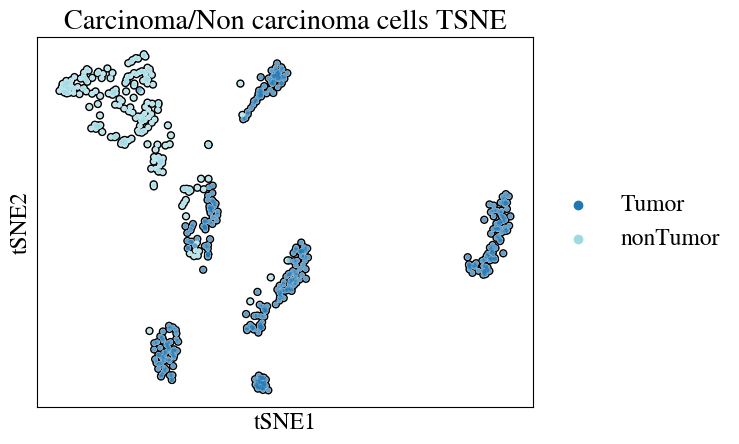

In [119]:
sc.pl.tsne(adata, color="Ground labels", title='Carcinoma/Non carcinoma cells TSNE', add_outline=True, size = 50,palette = "tab20")

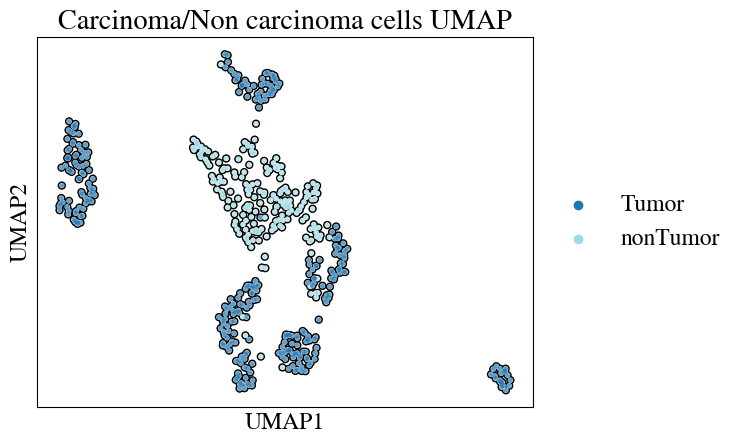

In [120]:
sc.pl.umap(adata, color="Ground labels", title='Carcinoma/Non carcinoma cells UMAP', add_outline=True, size = 50,palette = "tab20")

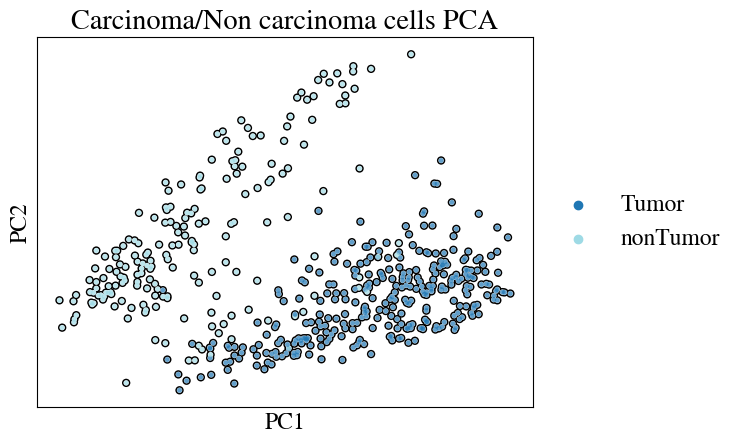

In [121]:
sc.pl.pca(adata, color="Ground labels", title='Carcinoma/Non carcinoma cells PCA', add_outline=True, size = 50,palette = "tab20")

## Evaluating the researchers' clustering results in the PCA space

In [122]:
# Optimal number of PC components is 9
data = adata.obsm['X_pca']
ground_labels = adata.obs['Ground labels']
score = silhouette_score(data,ground_labels)
print(f"The silhouete score in the optimal PCA space is: {score}")

The silhouete score in the optimal PCA space is: 0.13570980727672577


# **Our CLustering methodology**

### **Hierarchical: Average linkage**

The silhouete score in the optimal PCA space is: 0.17043377459049225
The adjusted random index (ARI) score with the original labels is: 0.0024496192405428405
The adjusted mutual information (AMI) score with to the original labels is: 0.0017466154601578497
The fowlkes mallows score with the original labels is: 0.7255439567547814


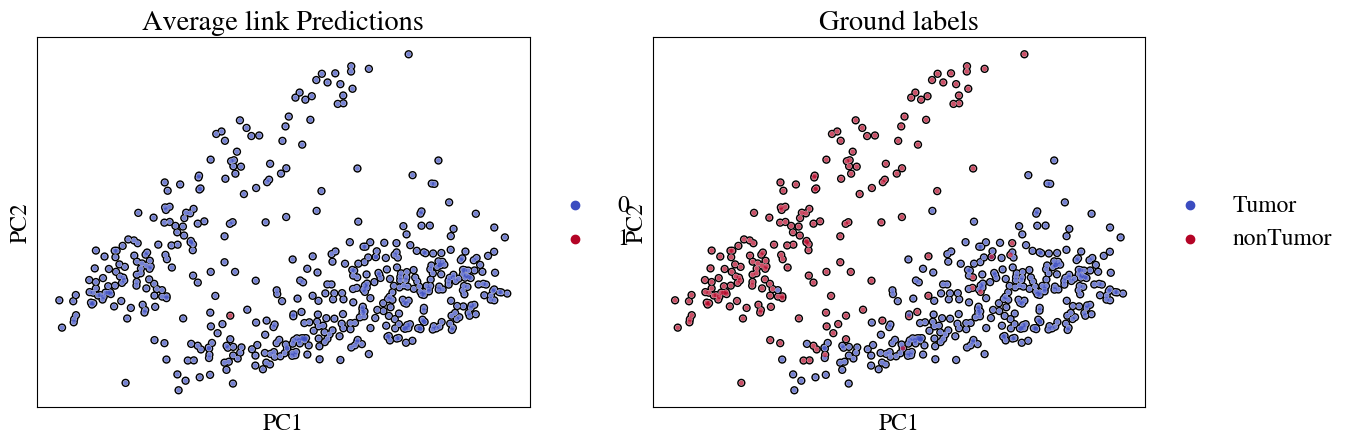

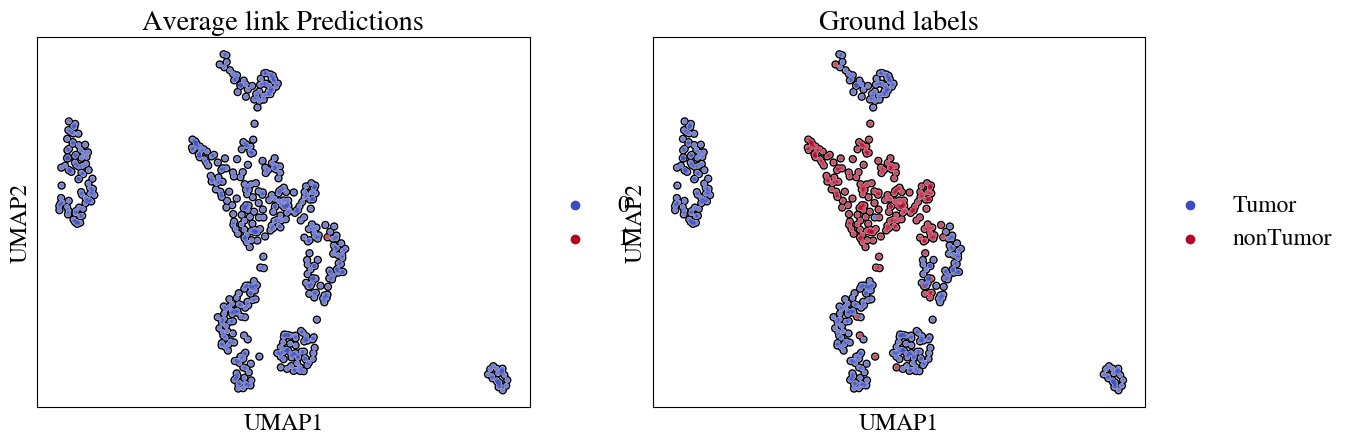

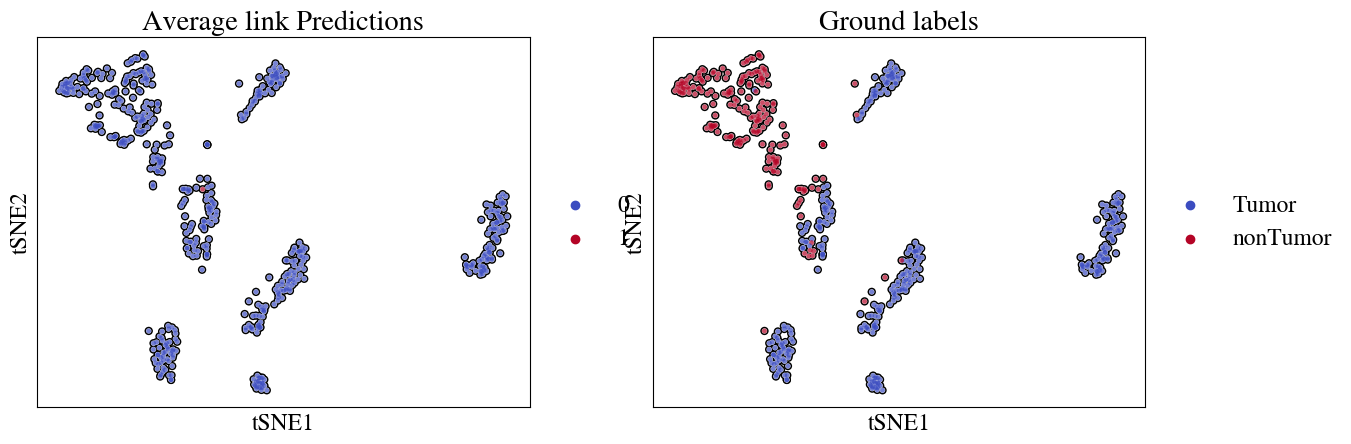

In [123]:

model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='average')
labels = model.fit_predict(data)
ha_score = silhouette_score(data,labels)
ha_ari = adjusted_rand_score(ground_labels, labels)
ha_ami = adjusted_mutual_info_score(ground_labels, labels)
ha_fow = fowlkes_mallows_score(ground_labels,labels)
print(f"The silhouete score in the optimal PCA space is: {ha_score}")
print(f"The adjusted random index (ARI) score with the original labels is: {ha_ari}")
print(f"The adjusted mutual information (AMI) score with to the original labels is: {ha_ami}")
print(f"The fowlkes mallows score with the original labels is: {ha_fow}")

adata.obs['Average link Predictions'] = labels.astype(str)

sc.pl.pca(adata, color=["Average link Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.umap(adata, color=["Average link Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.tsne(adata, color=["Average link Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")

### **Hierarchical: Ward linkage**

The silhouete score in the optimal PCA space is: 0.14094309508800507
The adjusted random index (ARI) score with the original labels is: 0.8775312377483108
The adjusted mutual information (AMI) score with to the original labels is: 0.7934429919980247
The fowlkes mallows score with the original labels is: 0.9424857827276705


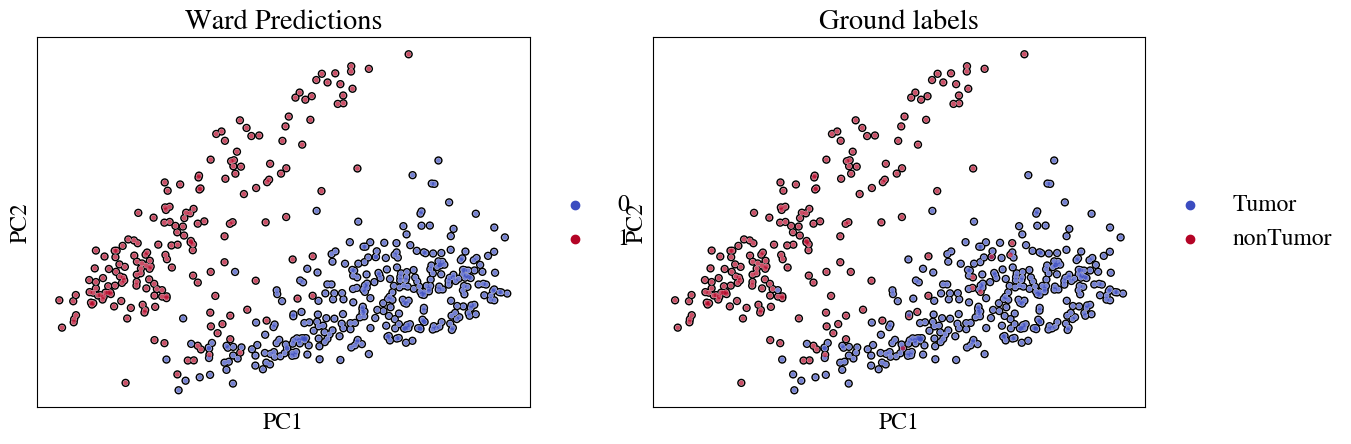

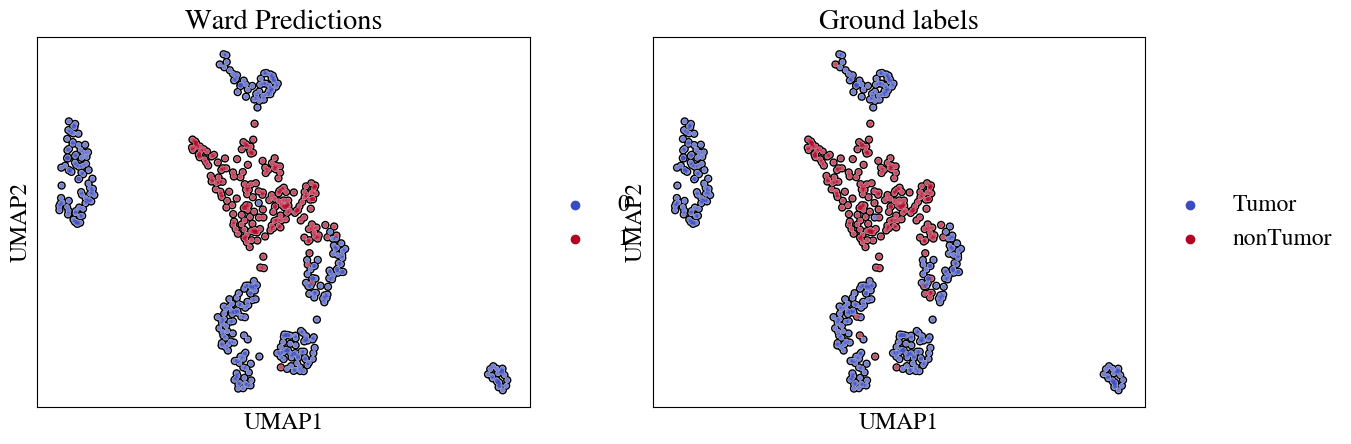

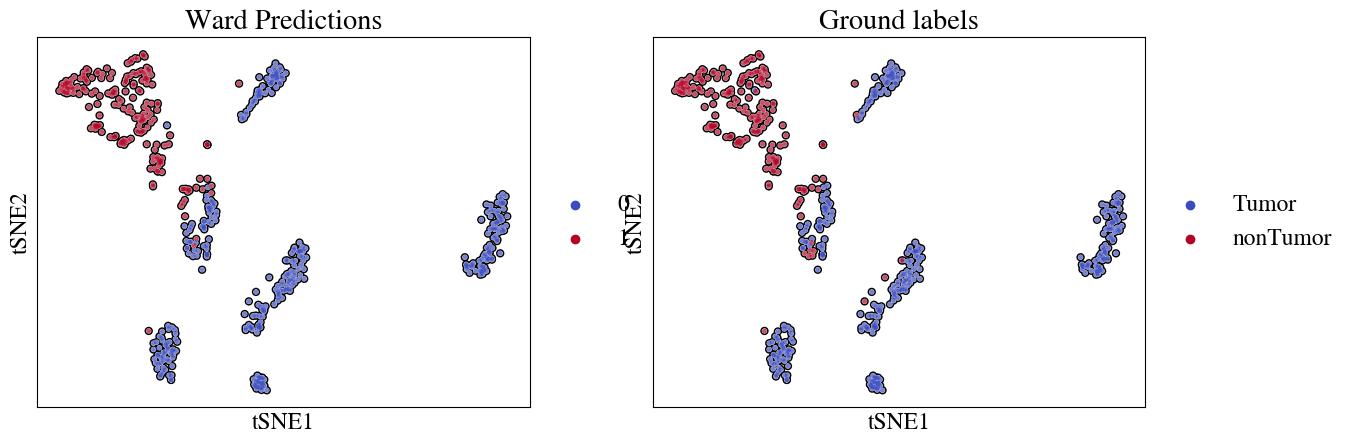

In [124]:

model = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
labels = model.fit_predict(data)
hw_score = silhouette_score(data,labels)
hw_ari = adjusted_rand_score(ground_labels, labels)
hw_ami = adjusted_mutual_info_score(ground_labels, labels)
hw_fow = fowlkes_mallows_score(ground_labels,labels)
print(f"The silhouete score in the optimal PCA space is: {hw_score}")
print(f"The adjusted random index (ARI) score with the original labels is: {hw_ari}")
print(f"The adjusted mutual information (AMI) score with to the original labels is: {hw_ami}")
print(f"The fowlkes mallows score with the original labels is: {hw_fow}")

adata.obs['Ward Predictions'] = labels.astype(str)

sc.pl.pca(adata, color=["Ward Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.umap(adata, color=["Ward Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.tsne(adata, color=["Ward Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")

### **Spectral Clustering**

In [125]:
def Spectral_trial(trial):
  n_neighbors = trial.suggest_int("n_neighbors",2,100)
  spectral = SpectralClustering(n_clusters=2,
                                affinity='nearest_neighbors',
                                n_neighbors=n_neighbors,
                                assign_labels="cluster_qr",
                                random_state=42)
  labels = spectral.fit_predict(data)
  try:
    return silhouette_score(data, labels, random_state=42)
  except ValueError:
  # Return the worst score if it does not converge
    return -1

pruner = optuna.pruners.HyperbandPruner()
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)
study.optimize(Spectral_trial, n_trials=100, show_progress_bar=True)

# Get the best parameters and objective value
best_params = study.best_params
best_value = study.best_value
print(best_params)

  0%|          | 0/100 [00:00<?, ?it/s]

{'n_neighbors': 77}


The silhouete score in the optimal PCA space is: 0.14479248225688934
The adjusted random index (ARI) score with the original labels is: 0.7093781437378265
The adjusted mutual information (AMI) score with to the original labels is: 0.6036373047556445
The fowlkes mallows score with the original labels is: 0.8606001393576796


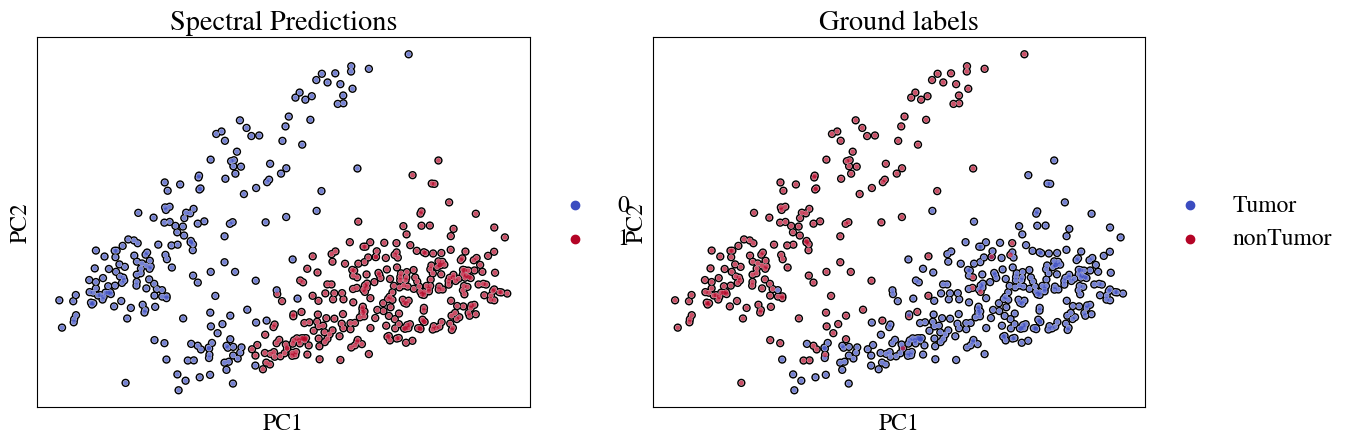

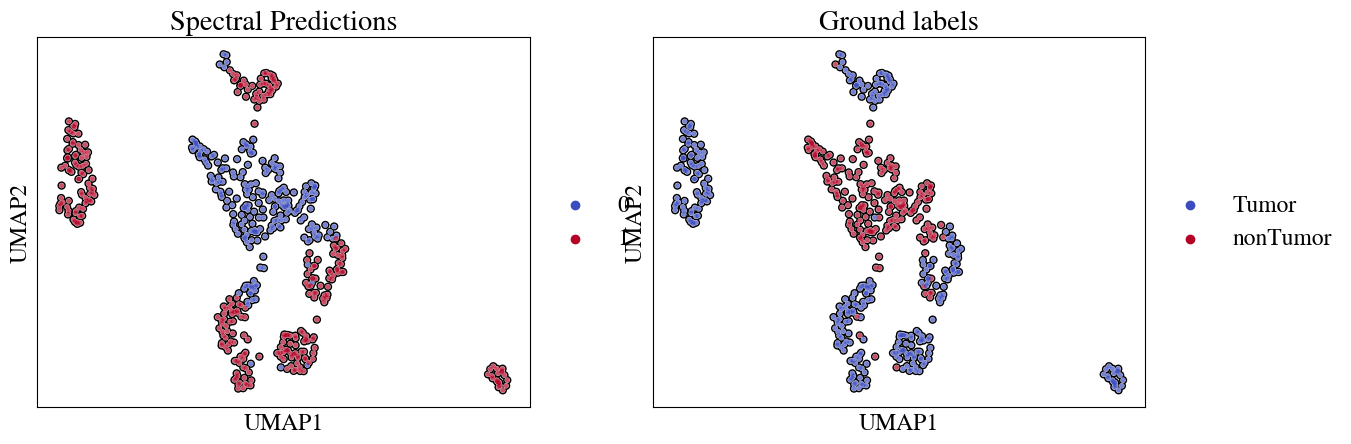

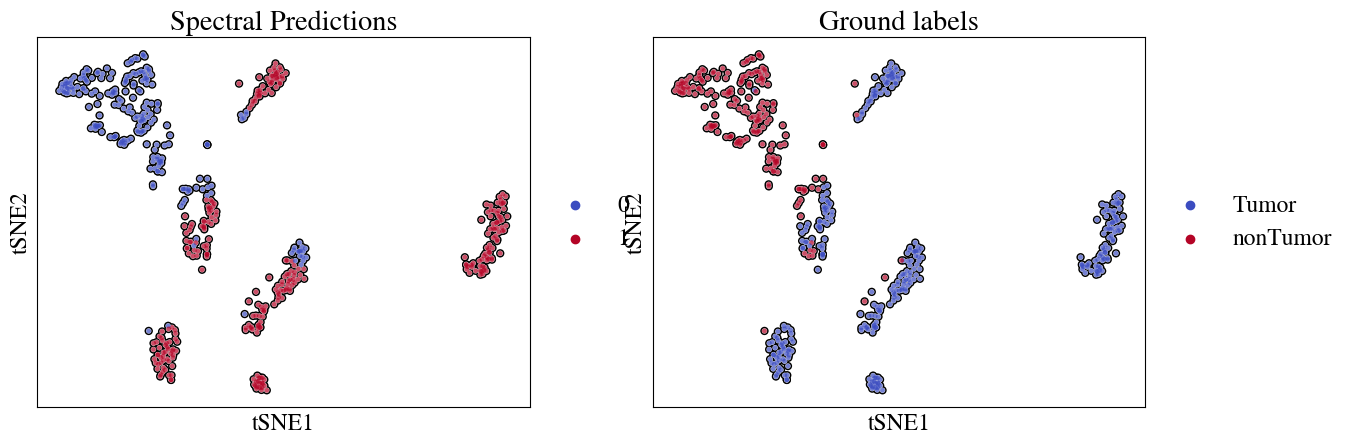

In [126]:
model = SpectralClustering(n_clusters=2,affinity='nearest_neighbors',n_neighbors=best_params['n_neighbors'],assign_labels="cluster_qr",random_state=42)
labels = model.fit_predict(data)
sp_score = silhouette_score(data,labels)
sp_ari = adjusted_rand_score(ground_labels, labels)
sp_ami = adjusted_mutual_info_score(ground_labels, labels)
sp_fow = fowlkes_mallows_score(ground_labels,labels)
print(f"The silhouete score in the optimal PCA space is: {sp_score}")
print(F"The adjusted random index (ARI) score with the original labels is: {sp_ari}")
print(F"The adjusted mutual information (AMI) score with to the original labels is: {sp_ami}")
print(f"The fowlkes mallows score with the original labels is: {sp_fow}")
adata.obs['Spectral Predictions'] = labels.astype(str)

sc.pl.pca(adata, color=["Spectral Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.umap(adata, color=["Spectral Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.tsne(adata, color=["Spectral Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")

### **GMM Clustering**


In [127]:
params, values = optimizeGMM(data,metric = "BIC",max_num_components = 2,show_progress_bar=False,n_trials=150)

The silhouete score in the optimal PCA space is: 0.14479248225688934
The adjusted random index (ARI) score with the original labels is: 0.7093781437378265
The adjusted mutual information (AMI) score with to the original labels is: 0.6036373047556445
The fowlkes mallows score with the original labels is: 0.5141021056753805


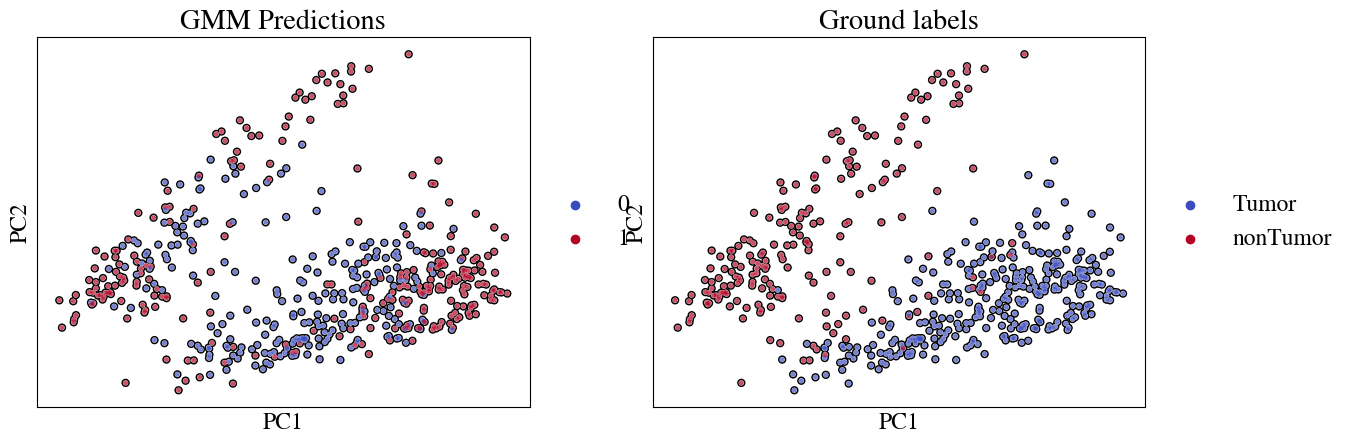

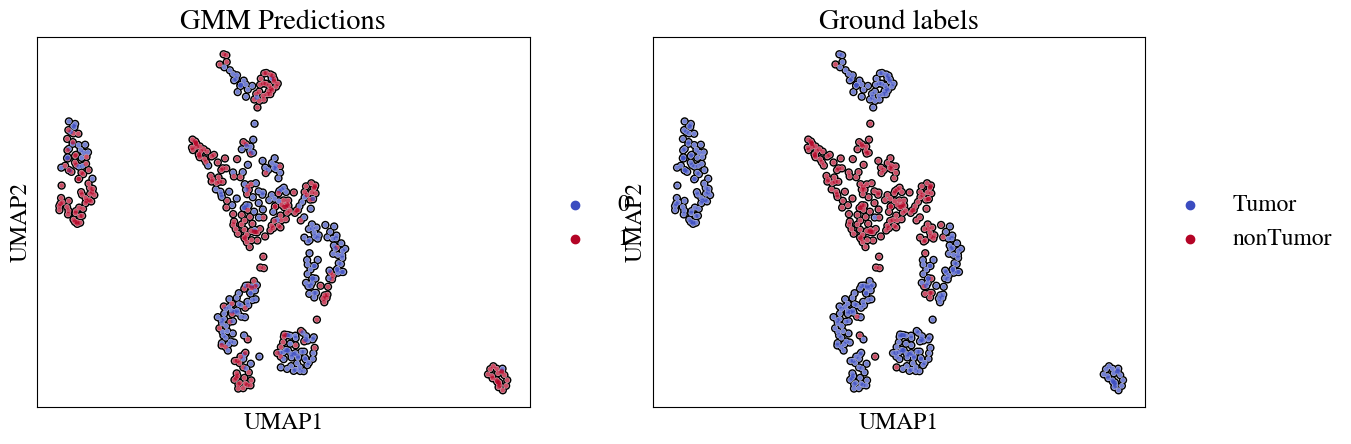

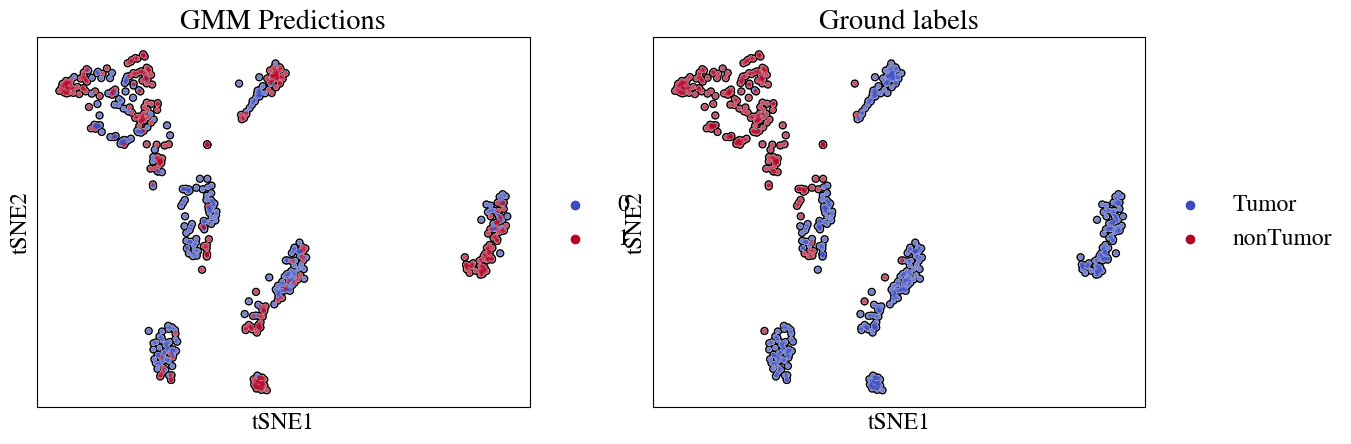

In [128]:
model = GaussianMixture(covariance_type=params[1]['covariance_type'],random_state = params[1]['random_state'],init_params=params[1]['init_params'],n_components=2)
labels = model.fit_predict(data)
gm_score = silhouette_score(data,labels)
gm_ari = adjusted_rand_score(ground_labels, labels)
gm_ami = adjusted_mutual_info_score(ground_labels, labels)
gm_fow = fowlkes_mallows_score(ground_labels,labels)
print(f"The silhouete score in the optimal PCA space is: {sp_score}")
print(f"The adjusted random index (ARI) score with the original labels is: {sp_ari}")
print(f"The adjusted mutual information (AMI) score with to the original labels is: {sp_ami}")
print(f"The fowlkes mallows score with the original labels is: {gm_fow}")
adata.obs['GMM Predictions'] = labels.astype(str)

sc.pl.pca(adata, color=["GMM Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.umap(adata, color=["GMM Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")
sc.pl.tsne(adata, color=["GMM Predictions",'Ground labels'],add_outline=True, size = 50, palette="coolwarm")

## Results

In [129]:
results_df = pd.DataFrame({"ARI (with original)": [0,hw_ari,ha_ari, sp_ari, gm_ari],
                          "AMI (with original)": [0,hw_ami,ha_ari, sp_ami, gm_ami],
                          "FMI (with original)":[0,hw_fow,ha_fow,sp_fow,gm_fow],
                          "silhouette": [score,hw_score,ha_score,sp_score, gm_score]})
results_df.index = ['Original Clustering','Ward Linkage','Average Linkage','Spectral',"GMM"]
results_df

,ARI (with original),AMI (with original),FMI (with original),silhouette
Original Clustering,0.000000,0.000000,0.000000,0.135710
Ward Linkage,0.877531,0.793443,0.942486,0.140943
Average Linkage,0.002450,0.002450,0.725544,0.170434
Spectral,0.709378,0.603637,0.860600,0.144792
GMM,0.000353,0.001729,0.514102,0.023908


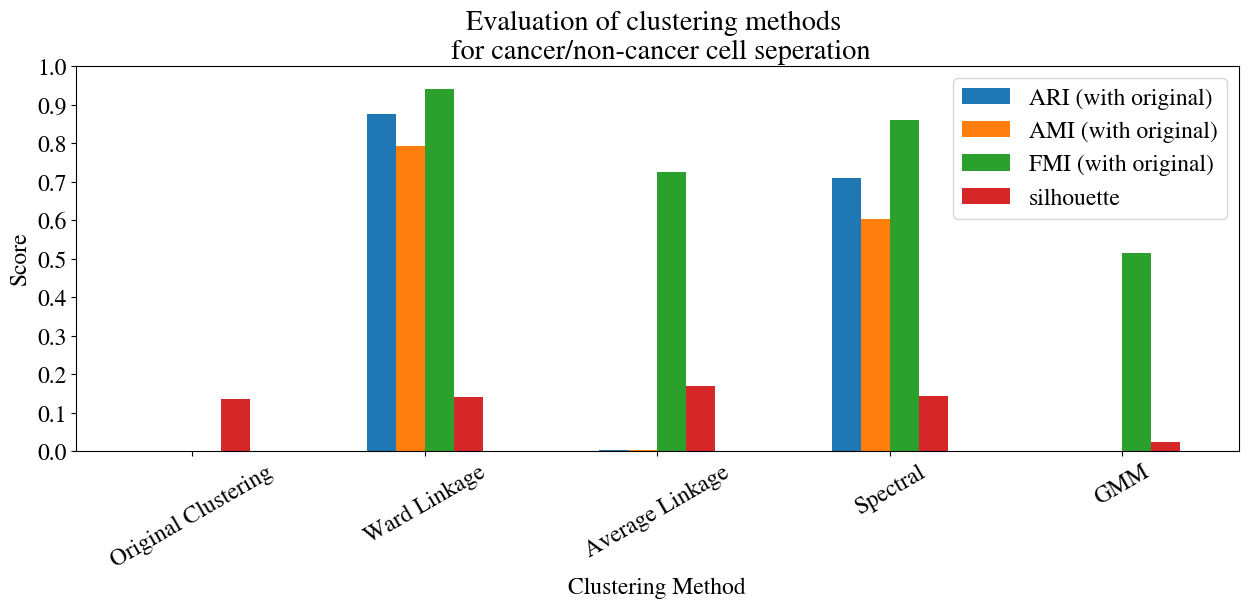

In [130]:
results_df.plot(kind='bar', rot=30,figsize=(15,5))
plt.title("Evaluation of clustering methods \n for cancer/non-cancer cell seperation")
plt.ylabel("Score")
plt.xlabel("Clustering Method")
plt.yticks(np.arange(0.0,1.1,0.1))
plt.show()

In [131]:
tumour_adata = adata[adata.obs['Ward Predictions'] == '0', :]
non_tumour_adata = adata[adata.obs['Ward Predictions'] == '1', :]

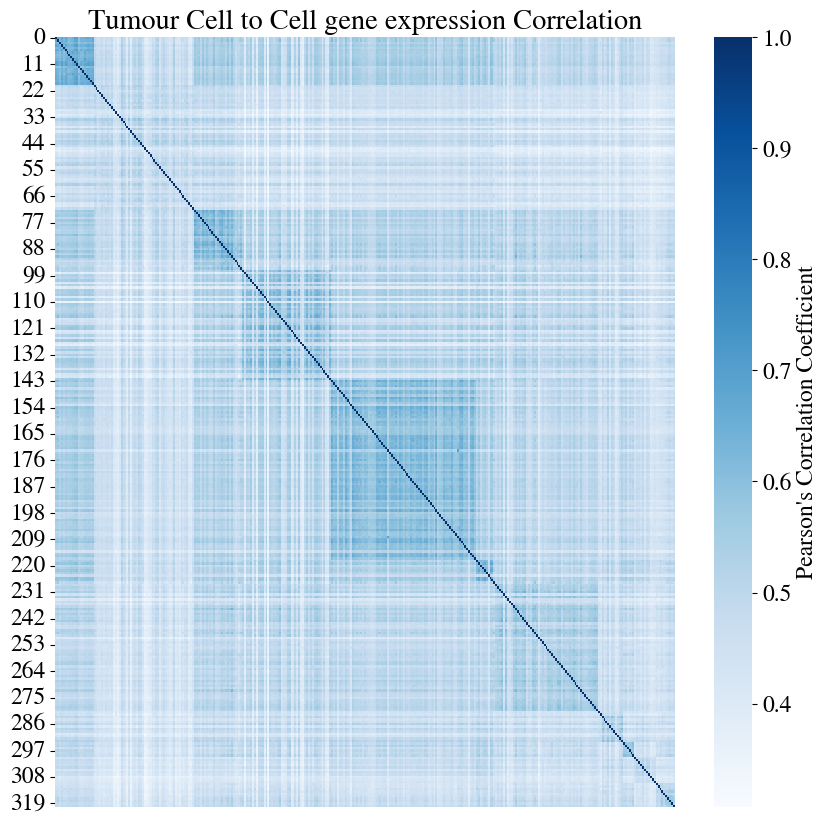

In [132]:
corr = np.corrcoef(tumour_adata.X)
plt.figure(figsize=(10,10))
sns.heatmap(corr,cmap="Blues",cbar_kws={"label":"Pearson's Correlation Coefficient"},xticklabels=False)
plt.title("Tumour Cell to Cell gene expression Correlation")
plt.show()

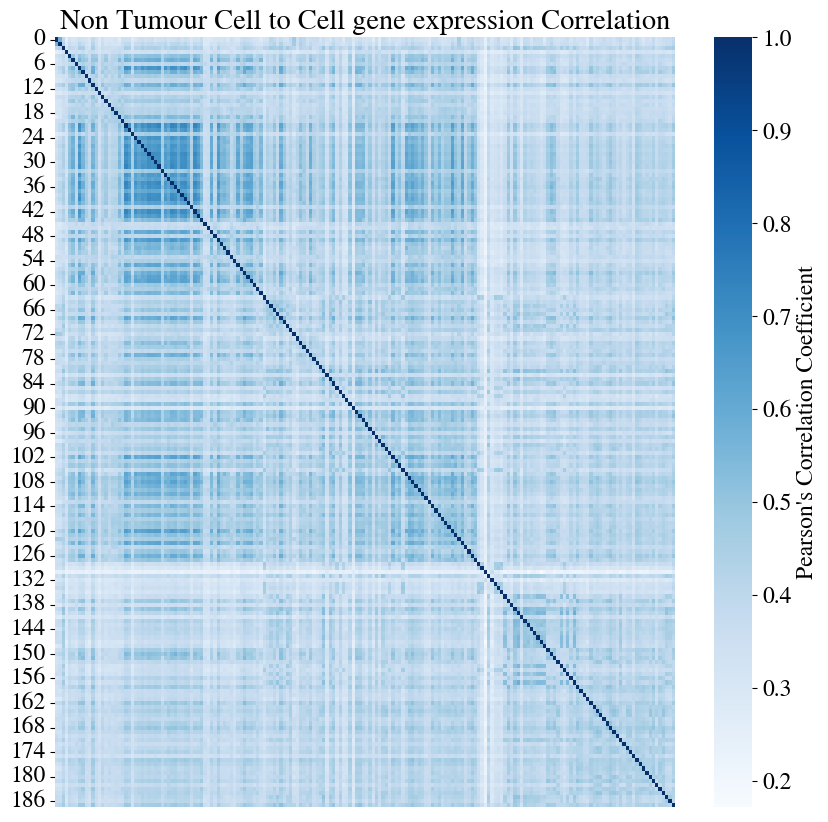

In [139]:
corr = np.corrcoef(non_tumour_adata.X)
plt.figure(figsize=(10,10))
sns.heatmap(corr,cmap="Blues",cbar_kws={"label":"Pearson's Correlation Coefficient"},xticklabels=False)
plt.title("Non Tumour Cell to Cell gene expression Correlation")
plt.show()

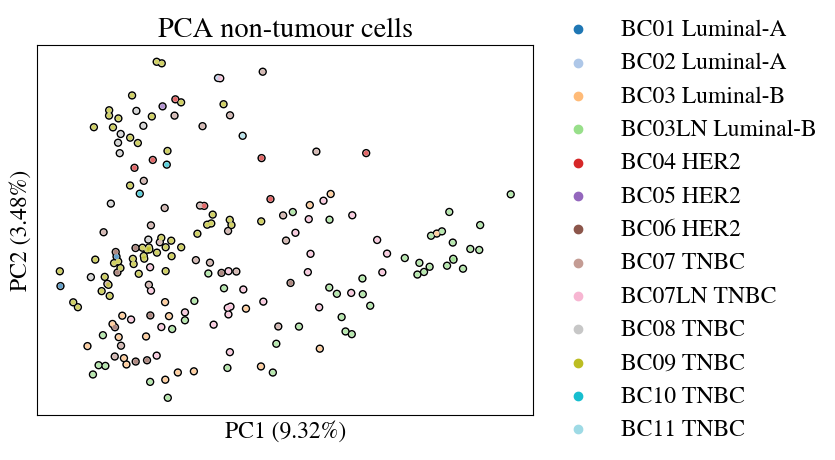

In [141]:
sc.pp.pca(non_tumour_adata)
sc.pl.pca(non_tumour_adata, color = 'tumor_groups',add_outline=True, size = 50,annotate_var_explained=True,title="PCA non-tumour cells")

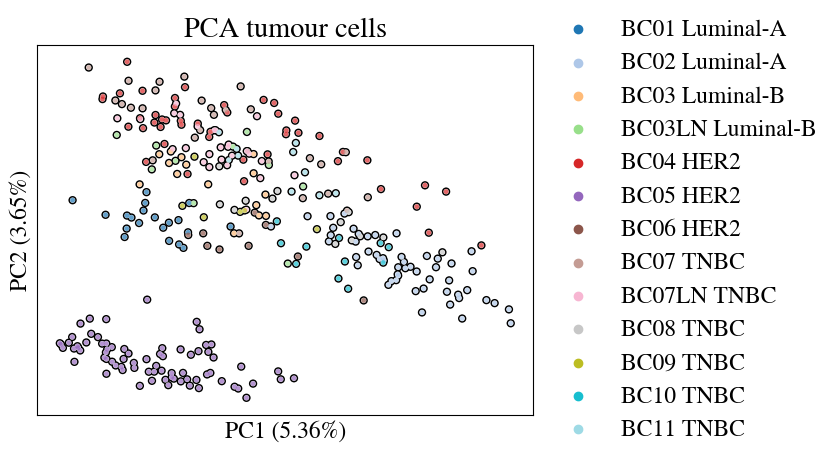

In [142]:
sc.pp.pca(tumour_adata)
sc.pl.pca(tumour_adata, color = 'tumor_groups',add_outline=True, size = 50,annotate_var_explained=True,title="PCA tumour cells")

In [143]:
tumour_adata.write("datasets/tumour_cellcounts.h5ad")
non_tumour_adata.write("datasets/nontumour_cellcounts.h5ad")